In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import corner
%matplotlib inline

# make things deterministic.
np.random.seed(0)

**Problem 1**

a) Let's call the hypothesis that the yellow M&M came from the 1994 bag (and thus, that the green one came from the 1996 bag) $H_{1}$. We'll call the opposite hypothesis $H_{2}$. The data $D$ is that one M&M is yellow and the other green. Then we can fill in the table, at the bottom of this cell.

- We were randomely given one from each bag, so the priors are each 50%.
- $P\left(D|H_{1}\right)$ is the probability that we'd get a yellow M&M from 1994 bag and a green one from the 1996 bag. It's $0.2 \times 0.2$. $P\left(D|H_{2}\right)$ is the probability that we'd get a green M&M from the 1994 bag and a yellow one from the 1996 bag. It's $0.1\times0.14$.
- Multiplying $P\left(H\right)P\left(D|H\right)$, we see that $H_{1}$ is $20/7$ times more likely that $H_{2}$.

b) We need $P\left(D\right)$, the probability that, if we draw an M&M from each bag, we'll get a green one and a yellow one. There are only two ways that this can happen, and they're $H_{1}$ and $H_{2}$. So we have $P\left(D\right)=0.02+0.007=0.027$. Dividing through, we get the absolute probabilities. 
 


|       | P($ $H) | P(D$|$H) | P(H)P(D$|$H) | P(H$|$D) |
|-------|--------|----------|--------------|----------|
| $H_1$ | 1/2    |   0.04   | 0.02         | 20/27    |
| $H_2$ | 1/2    |   0.014  | 0.007        | 7/27     | 

In [2]:
# Problem 2

def gaussian(x, mu = 5, sigma = 1):
    '''
    The probability distribution from which we're sampling 
    '''
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(mu - x)**2 / (2*sigma**2))

def log_gaussian(x, mu = 5, sigma = 1):
    '''
    Easier to sample small probabilities from a log distribution 
    '''
    return -0.5*np.log(2*np.pi*sigma**2) - (mu - x)**2/(2*sigma**2)

def get_dimension(theta):
    '''
    helper function
    '''
    try:
        dim = len(theta)
    except TypeError:
        dim = 1
    return dim
def gauss_prop(x0, sigma = 1):
    '''
    the "proposal distribution". We'll use a Gaussian. 
    suggests a new value x1 to try, given a current value x0.
    In the interest of generality, make everything work for multiple
    dimensions. 
    '''
    x1 = x0 + sigma * np.random.randn(get_dimension(x0))
    return x1

def get_log_alpha(log_P, x0, x1):
    '''
    given a current position x0 and a proposed position x1, calculate alpha. 
    Here log_P is a function.
    '''
    return log_P(x1) - log_P(x0)
    
def should_we_move(log_P, x0, x1):
    '''
    the "accept the candidate with probability alpha" step. Returns True if 
    you should accept x1; False otherwise. 
    '''
    log_alpha = get_log_alpha(log_P = log_P, x0 = x0, x1 = x1)
    #print(x0, x1, log_alpha)
    if log_alpha >= 0:
        return True
    else:
        # generate a random number between 0 and 1
        rand_num = np.random.uniform(size = 1)
        
        if np.exp(log_alpha) >= rand_num:
            return True
        else:
            return False
        
def get_n_metropolis_hasting_samples(log_P, x0, n = 10000, step = 1):
    '''
    draw n samples from a pdf P. 
    gonna be slow, because it's pure python and isn't efficiently 
    using numpy or anything, but good enough for our purposes
    '''
    samples, num_samples = [x0], 1
    
    while num_samples < n:
        x_cur = samples[num_samples - 1]
        x_prop = gauss_prop(x0 = x_cur, sigma = step)
        
        if should_we_move(log_P = log_P, x0 = x_cur, x1 = x_prop):
            samples.append(x_prop)
        else:
            samples.append(x_cur)
        num_samples += 1
    
    return samples

def get_acceptance_fraction(samples):
    '''
    check what fraction of the time the chain accepts the proposal
    and moves on
    '''
    num_accepted = 0
    for i, theta in enumerate(samples[1:]):
        if np.array_equal(samples[i-1], samples[i]):
            # if two consecutive thetas are equal, proposal was not accepted
            continue
        num_accepted += 1
        
    return num_accepted/(len(samples)-1)
        

In [3]:
# test it
samples = get_n_metropolis_hasting_samples(log_P = log_gaussian, x0 = 4, n = 1e6, step = 2.5)
# not too bad. Takes ~15 seconds for a million samples on my laptop, which is super slow and old. 

# is the acceptance fraction ok?
get_acceptance_fraction(samples)
# seems reasonable

0.4293934293934294

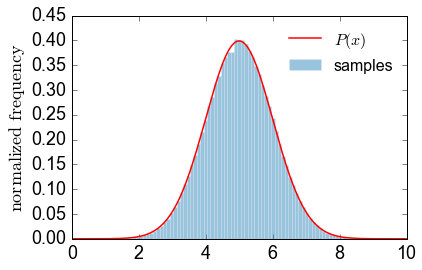

In [4]:
f = plt.figure(figsize = (6, 4))
ax = f.add_subplot(111)
ax.grid(False)

# histogram of the points
_ = ax.hist(samples, bins = np.linspace(0, 10, 100), alpha = 0.5, normed = True,
           label = 'samples')

# compare to P(x)
xx = np.linspace(0, 10, 1000)
ax.plot(xx, gaussian(xx), 'r', label = r'$P(x)$')
ax.legend(frameon = False, fontsize = 16)
ax.set_ylabel(r'${\rm normalized\,frequency}$', fontsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
ax.yaxis.set_tick_params(labelsize = 18)

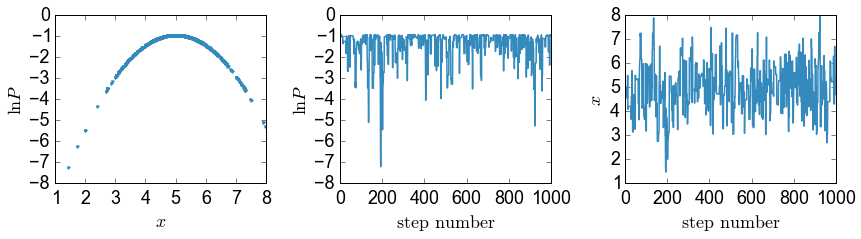

In [5]:
'''looks good. Couple more diagnostic plots to make sure 
we're converging on a steady state'''

# just plot the first 1000 samples. Otherwise this is 
# going to get too crowded 
x = samples[:1000]

fig, ax = plt.subplots(1, 3, figsize = (14, 3))

xlabels = [r'$x$', r'${\rm step\,number}$', r'${\rm step\,number}$']
ylabels, markers = [r'$\ln P$', r'$\ln P$', r'$x$'], ['.', '-', '-']
xs, ys = [x, np.arange(len(x)), np.arange(len(x))], \
        [np.log(np.vectorize(gaussian)(x)), np.log(np.vectorize(gaussian)(x)), x]
for i in range(3):
    ax[i].grid(False)
    ax[i].xaxis.set_tick_params(labelsize = 18)
    ax[i].yaxis.set_tick_params(labelsize = 18)
    ax[i].set_ylabel(ylabels[i], fontsize = 18)
    ax[i].set_xlabel(xlabels[i], fontsize = 18)
    ax[i].plot(xs[i], ys[i], markers[i])
    
plt.subplots_adjust(wspace = 0.35)

# ok, I'm satisfied

In [6]:
# Problem 3
def generate_fake_line_data(m, b, max_sigma, n_points = 10):
    '''
    for simplicity, always distibutes 'x' values between
    between 0 and 2m. 
    
    In general, the uncertainty on each data point is differnt. I'll
    choose uncertainties between max_sigma/5 and max_sigma. (So no
    points with *really* small errors that dominate the fit.) 
    
    Note that in the general case, there's no
    reason points should all have the same uncertainty. But, the 
    uncertainty should *not* just be the difference between the 
    point and the model prediction (in the example Dan posted, 
    it is). If uncertanties are reported correctly, only ~68% of 
    the error bars should touch the model line. 
    '''
    x_i = np.sort(np.random.uniform(0, 2*m, n_points))
    y_i = m*x_i + b 
    sigmas = np.random.uniform(max_sigma/5, max_sigma, n_points)
    y_i += sigmas * np.random.randn(n_points)
    
    return x_i, y_i, sigmas


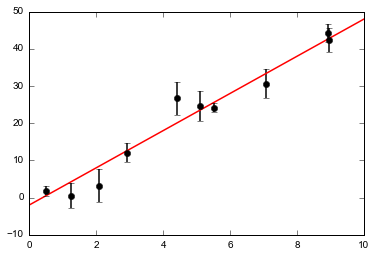

In [7]:
# start with the case of 10 points
np.random.seed(3)
x_i10, y_i10, sigmas10 = generate_fake_line_data(m = 5, b = -2, 
                        max_sigma = 6, n_points = 10)

xx = np.linspace(0, 10)
plt.plot(xx, 5*xx - 2, 'r')
plt.errorbar(x_i10, y_i10, yerr = sigmas10, fmt = 'ko')
plt.grid(False)


In [8]:
def line_model(x, m, b):
    return m*x + b

def line_log_likelihood(m, b, x_i, y_i, sigma_i, model = line_model):
    '''
    model(**kwargs) is a function. 
    '''
    return -0.5 * np.sum((y_i - model(x = x_i, m = m, b = b))**2/sigma_i**2 +
                        np.log(2*np.pi*sigma_i**2))

def line_log_prior(m, b):
    '''
    assume, fairly arbitrarily (say we just eyeballed the data to
    get our prior), that m is between 3 and 6, and b is between -10 and 5
    '''
    if (3 < m < 6) and (-20 < b < 5):
        return 0
    else:
        return -np.inf
    
def line_log_post(theta, x_i, y_i, sigma_i, model = line_model):
    '''
    
    '''
    m, b = theta
    return line_log_prior(m = m, b = b) + line_log_likelihood(model = model, 
                m = m, b = b, x_i = x_i, y_i = y_i, sigma_i = sigma_i)

def draw_samples_from_post_met_hastings(log_post, model, x_i, y_i, sigma_i, 
        theta0 = [4, 0], step_sizes = [1, 0.5], n_samples = 1e4):
    '''
    step_sizes correspond to steps in b and m. 
    '''
    theta0, step_sizes = np.array(theta0), np.array(step_sizes)
    
    def this_logP(theta):      
        return log_post(theta, x_i = x_i, y_i = y_i, sigma_i = sigma_i)
    
    samples = get_n_metropolis_hasting_samples(log_P = this_logP, 
                x0 = theta0, n = n_samples, step = step_sizes)
    
    return np.array(samples)

In [9]:
samples10 = draw_samples_from_post_met_hastings(log_post = line_log_post, model = line_model, 
            x_i = x_i10, y_i = y_i10, sigma_i = sigmas10, step_sizes = [0.5, 1], theta0 = [4, 0],
            n_samples = 1e5)

In [10]:
def plot_convergence(samples):
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 3.5))
    labels = [r'$m$', r'$b$']
    for i in range(2):
        ax[i].grid(False)
        ax[i].plot(samples[:, i],)
        ax[i].set_ylabel(labels[i], fontsize = 20)
        ax[i].set_xlabel(r'${\rm step\,number}$', fontsize = 20)

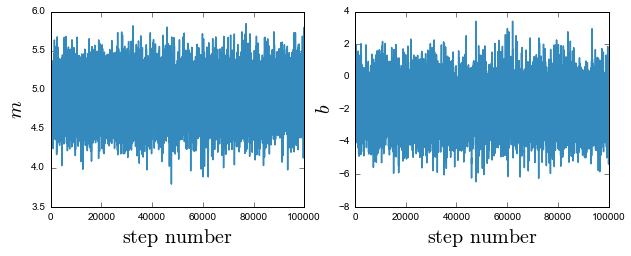

In [11]:
plot_convergence(samples10)

In [12]:
# I just played around with the step sizes to get an acceptance ratio 
# seems to converge quickly, but we'll throw out the first 20% of points to be safe. 
good_samples10 = samples10[20000:]
get_acceptance_fraction(good_samples10)

0.2804535056688209

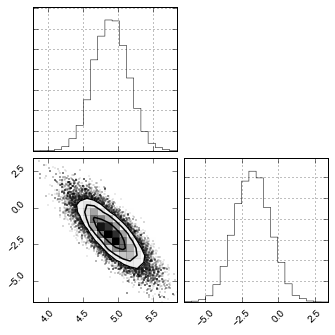

In [13]:
_ = corner.corner(good_samples10)

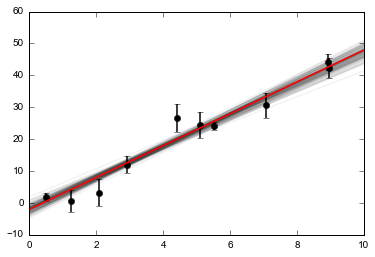

In [14]:
# show some of the mcmc fits
def show_some_lines(good_samples, x_i, y_i, sigma_i):

    randints = np.random.randint(0, len(good_samples), 100)

    xx = np.linspace(0, 10)
    plt.errorbar(x_i, y_i, yerr = sigma_i, fmt = 'ko')
    plt.grid(False)

    for i, intrg in enumerate(randints):
        this_m, this_b = good_samples[intrg]
        plt.plot(xx, this_m*xx + this_b, 'k', alpha = 0.05)
    plt.plot(xx, 5*xx - 2, 'r')

show_some_lines(good_samples10, x_i10, y_i10, sigmas10)

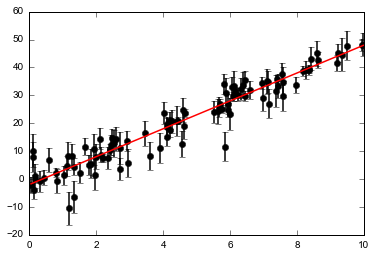

In [15]:
# that was 10 points. Let's do 100. 

x_i100, y_i100, sigmas100 = generate_fake_line_data(m = 5, b = -2, 
                        max_sigma = 6, n_points = 100)

plt.errorbar(x_i100, y_i100, yerr = sigmas100, fmt = 'ko')
plt.plot(x_i100, 5*x_i100 - 2, 'r')
plt.grid(False)

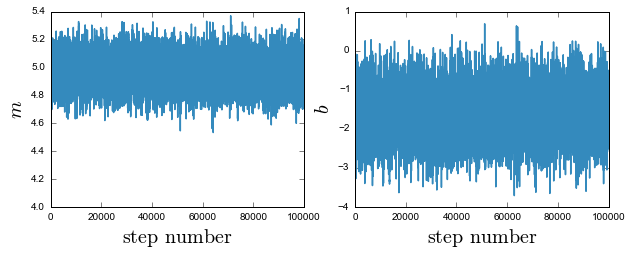

In [16]:
samples100 = draw_samples_from_post_met_hastings(log_post = line_log_post, model = line_model, 
            x_i = x_i100, y_i = y_i100, sigma_i = sigmas100, step_sizes = [0.15, 0.5],
            n_samples = 1e5)
plot_convergence(samples100)

In [17]:
good_samples100 = samples100[20000:]
get_acceptance_fraction(good_samples100)
# ok

0.2947911848898111

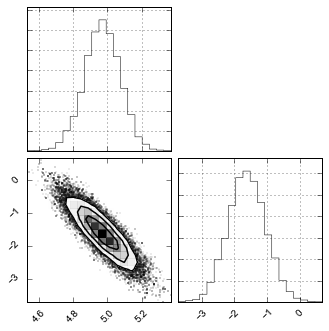

In [18]:
_ = corner.corner(good_samples100)

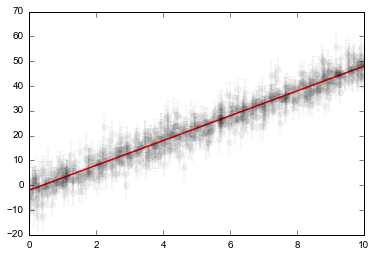

In [19]:
# Now 1000 points. 

x_i1000, y_i1000, sigmas1000 = generate_fake_line_data(m = 5, b = -2, 
                        max_sigma = 6, n_points = 1000)

plt.plot(x_i1000, 5*x_i1000 - 2, 'r')
plt.errorbar(x_i1000, y_i1000, yerr = sigmas1000, fmt = 'ko', alpha = 0.05)
plt.grid(False)


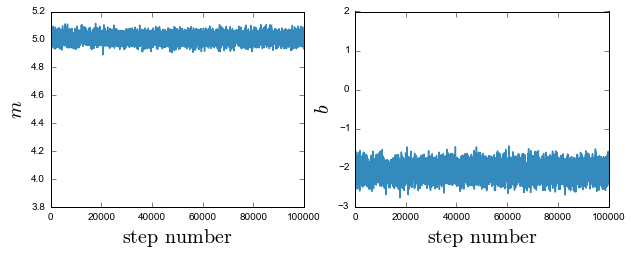

In [20]:
samples1000 = draw_samples_from_post_met_hastings(log_post = line_log_post, model = line_model, 
            x_i = x_i1000, y_i = y_i1000, sigma_i = sigmas1000, step_sizes = [0.02, 0.3],
            n_samples = 1e5)
plot_convergence(samples1000)

In [21]:
good_samples1000 = samples1000[20000:]
get_acceptance_fraction(good_samples1000)

0.27712846410580133

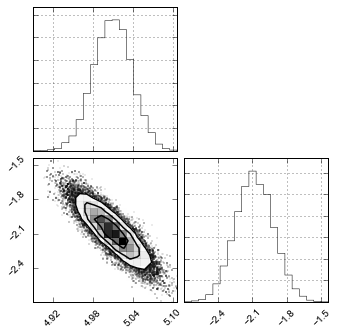

In [22]:
_ = corner.corner(good_samples1000)

In [23]:
# Now the same thing, but with emcee
import emcee

def run_emcee(x_i, y_i, sigma_i, p0 = [4, 0], nwalkers = 500, samples_per_walker = 200,
             burn_period = 100):
    '''
    generate starting positions, run, and return a sampler object
    '''
    ndim = len(p0)
    ball_of_p0 = [p0 + 0.01*np.random.randn(ndim) for i in range(nwalkers)]
    
    # run for a bit to get good starting points
    sampler = emcee.EnsembleSampler(nwalkers, ndim, line_log_post, 
                                    args=[x_i, y_i, sigma_i, line_model])
    pos, prob, state = sampler.run_mcmc(ball_of_p0, burn_period)
    sampler.reset()
    
    # now the main production run
    sampler.run_mcmc(pos, samples_per_walker)
    
    return sampler

In [24]:
sampler10 = run_emcee(x_i = x_i10, y_i = y_i10, sigma_i = sigmas10)

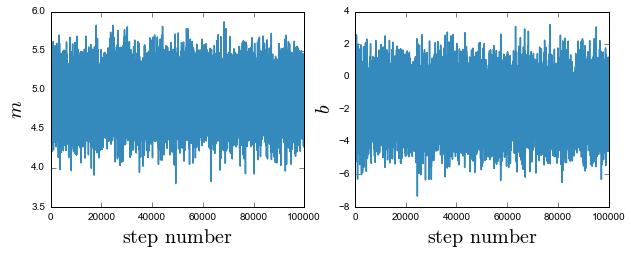

In [25]:
plot_convergence(sampler10.flatchain)

In [26]:
np.mean(sampler10.acceptance_fraction)
# hmm, kind of high. Almost certainly doesn't matter 
# for this many samples, but it isn't ideal. 

0.71335000000000004

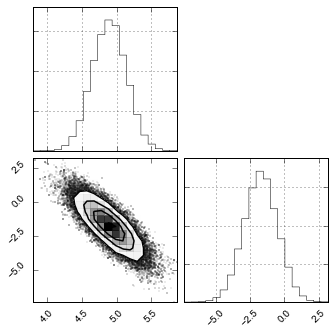

In [27]:
_ = corner.corner(sampler10.flatchain)

In [28]:
# now the 100 points...
sampler100 = run_emcee(x_i = x_i100, y_i = y_i100, sigma_i = sigmas100)

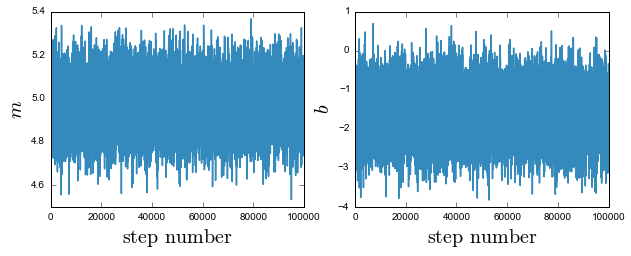

In [29]:
plot_convergence(sampler100.flatchain)

In [30]:
np.mean(sampler100.acceptance_fraction)


0.71589999999999998

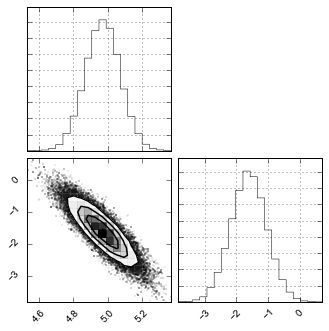

In [31]:
_ = corner.corner(sampler100.flatchain)

In [32]:
sampler1000 = run_emcee(x_i = x_i1000, y_i = y_i1000, sigma_i = sigmas1000)

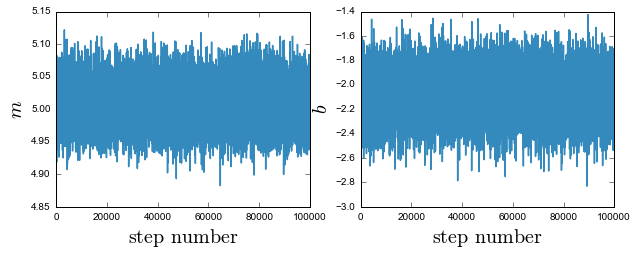

In [33]:
plot_convergence(sampler1000.flatchain)

In [34]:
np.mean(sampler1000.acceptance_fraction)


0.71538999999999997

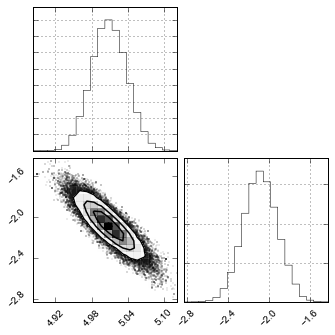

In [35]:
_ = corner.corner(sampler1000.flatchain)

In [ ]:
#comment